In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import regressionSummary, classificationSummary, exhaustive_search
from dmba import adjusted_r2_score, AIC_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Load dataset

shipment_df = pd.read_csv('DataCoSupplyChainDataset.csv')
shipment_df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [4]:
#Replace space with underscore to all columns

shipment_df.columns = shipment_df.columns.str.replace(' ', '_')
shipment_df.columns

Index(['Type', 'Days_for_shipping_(real)', 'Days_for_shipment_(scheduled)',
       'Benefit_per_order', 'Sales_per_customer', 'Delivery_Status',
       'Late_delivery_risk', 'Category_Id', 'Category_Name', 'Customer_City',
       'Customer_Country', 'Customer_Email', 'Customer_Fname', 'Customer_Id',
       'Customer_Lname', 'Customer_Password', 'Customer_Segment',
       'Customer_State', 'Customer_Street', 'Customer_Zipcode',
       'Department_Id', 'Department_Name', 'Latitude', 'Longitude', 'Market',
       'Order_City', 'Order_Country', 'Order_Customer_Id',
       'order_date_(DateOrders)', 'Order_Id', 'Order_Item_Cardprod_Id',
       'Order_Item_Discount', 'Order_Item_Discount_Rate', 'Order_Item_Id',
       'Order_Item_Product_Price', 'Order_Item_Profit_Ratio',
       'Order_Item_Quantity', 'Sales', 'Order_Item_Total',
       'Order_Profit_Per_Order', 'Order_Region', 'Order_State', 'Order_Status',
       'Order_Zipcode', 'Product_Card_Id', 'Product_Category_Id',
       'Product_De

In [5]:
#Changing the format of the dates columns 

shipment_df["shipping_date_(DateOrders)"]= pd.to_datetime(shipment_df["shipping_date_(DateOrders)"])
shipment_df["order_date_(DateOrders)"]= pd.to_datetime(shipment_df["order_date_(DateOrders)"])

In [6]:
#Spliting the data frame into quantitative & qualitative data 

shipment_df_quant = shipment_df.select_dtypes(include=['number'])
shipment_df_qual = shipment_df.select_dtypes(include=['object'])

### Data Visualization

Text(0.5, 1.0, 'the correlation coefficient between the quantitative variables')

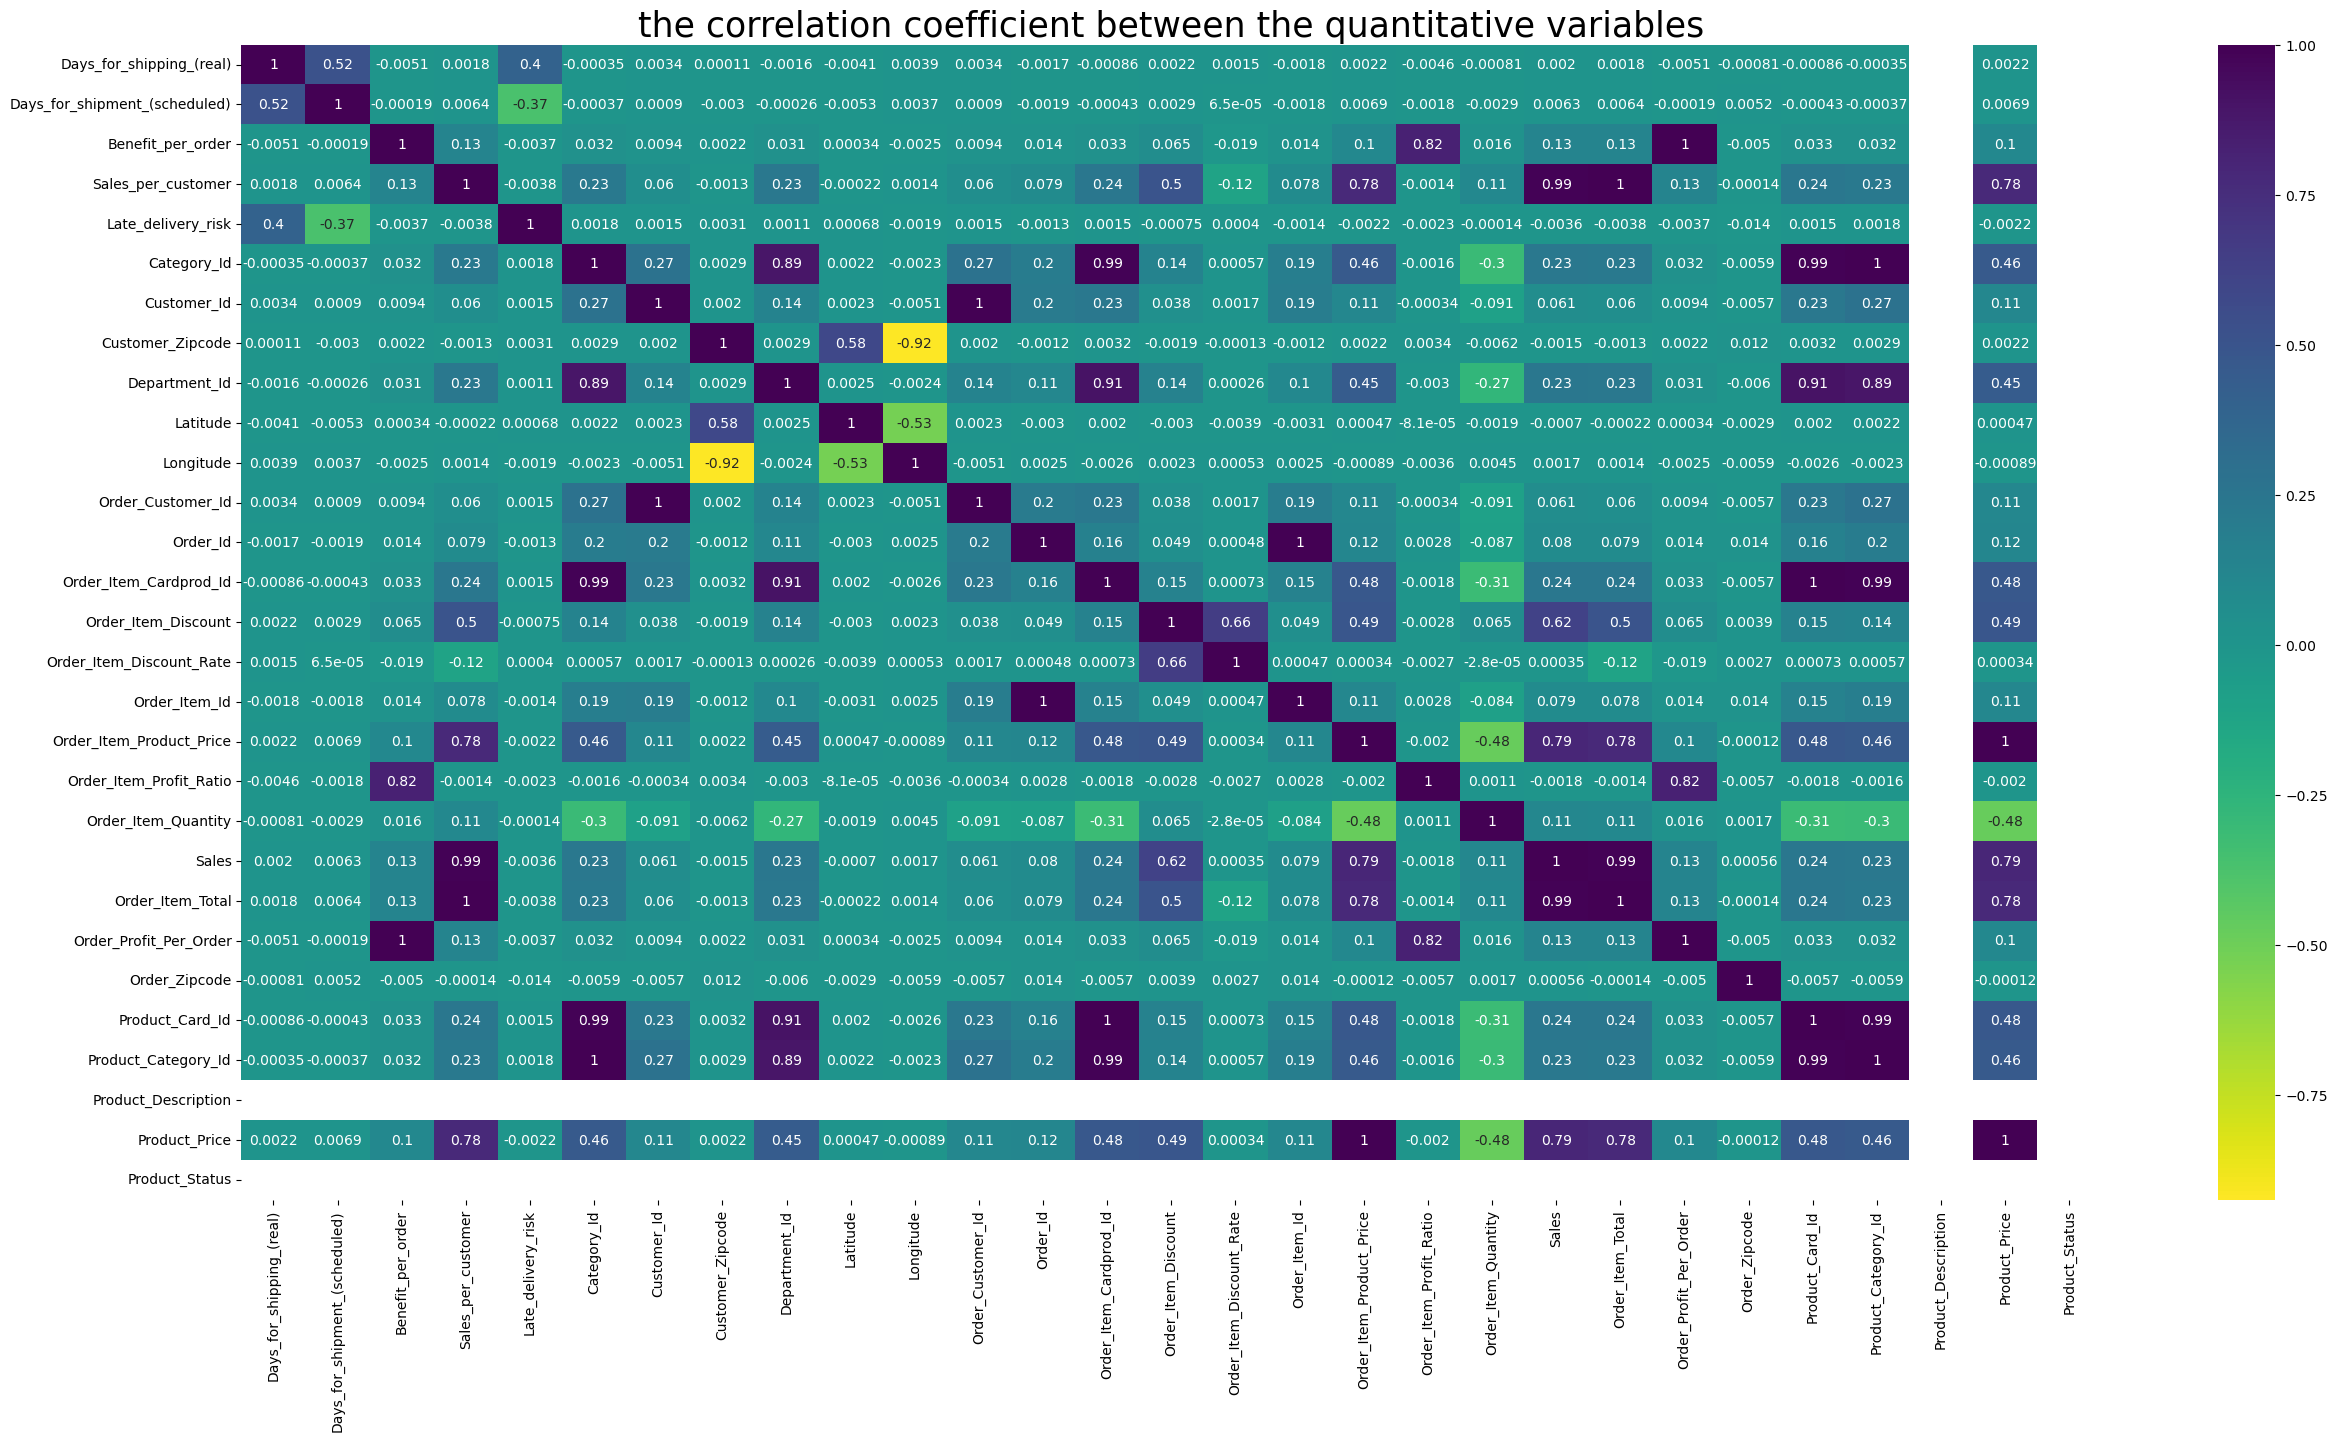

In [7]:
#Display correlation between the quantitative varibles 

plt.rcParams["figure.figsize"] = 30,15
sns.heatmap(shipment_df_quant.corr(),cmap='viridis_r',annot= True)
plt.title("the correlation coefficient between the quantitative variables",size = 25)

#### Note:

-It is clear that the increase in scheduled shipping days reduces the risk of late delivery because the correlation coefficient between scheduled shipping days and the risk of late delivery is (-0.37). that means it's better to increase the scheduled shipping date to give more opportunity to reach the shipment on time.

-Sales and the discount has a clear positive correlation (0.62)

-order item product price and item quantatity (-048) . that make us understand that the more expensive products the less quantity is ordered.

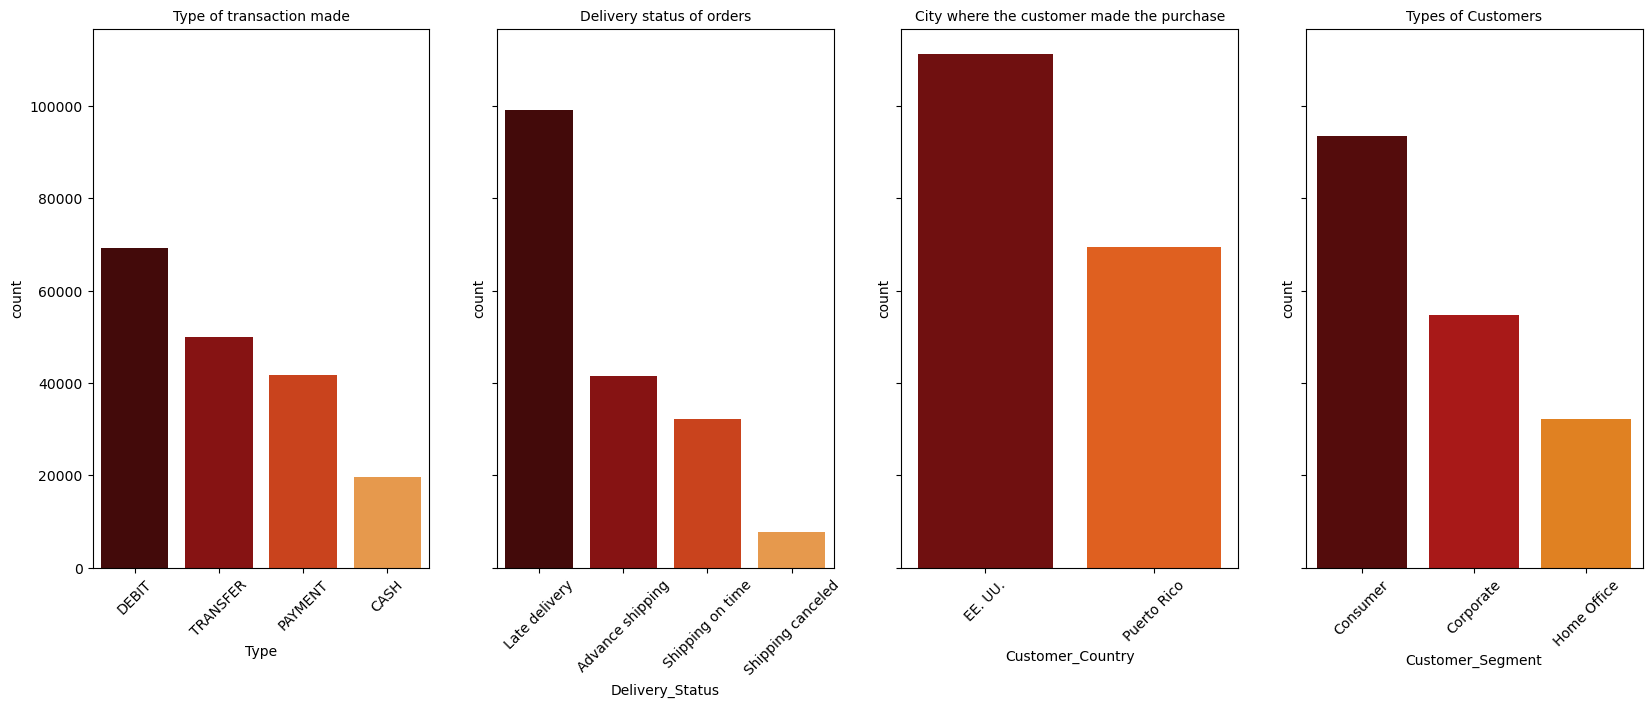

In [8]:
#Display Bar Charts (side-by-side) of Type of transaction made, Delivery status of orders, City where the customer made the purchase, Types of Customers

plt.rcParams["figure.figsize"] = 20, 7

def categ_count_x_side_by_side(categ_vars, titles):
    fig, axes = plt.subplots(1, len(categ_vars), sharey=True)

    for i, categ_var in enumerate(categ_vars):
        sns.countplot(data = shipment_df, x = shipment_df[categ_var], order = shipment_df[categ_var].value_counts().index, palette = 'gist_heat', ax = axes[i])
        axes[i].set_title(titles[i], size = 10)
        axes[i].set_xlabel(categ_var)
        axes[i].tick_params(axis = 'x', rotation = 45) #Rotate x-axis labels by 45 degrees

    plt.show()

categ_vars = ["Type", "Delivery_Status", "Customer_Country", "Customer_Segment"]
titles = ["Type of transaction made", "Delivery status of orders", "City where the customer made the purchase", "Types of Customers"]

categ_count_x_side_by_side(categ_vars, titles)

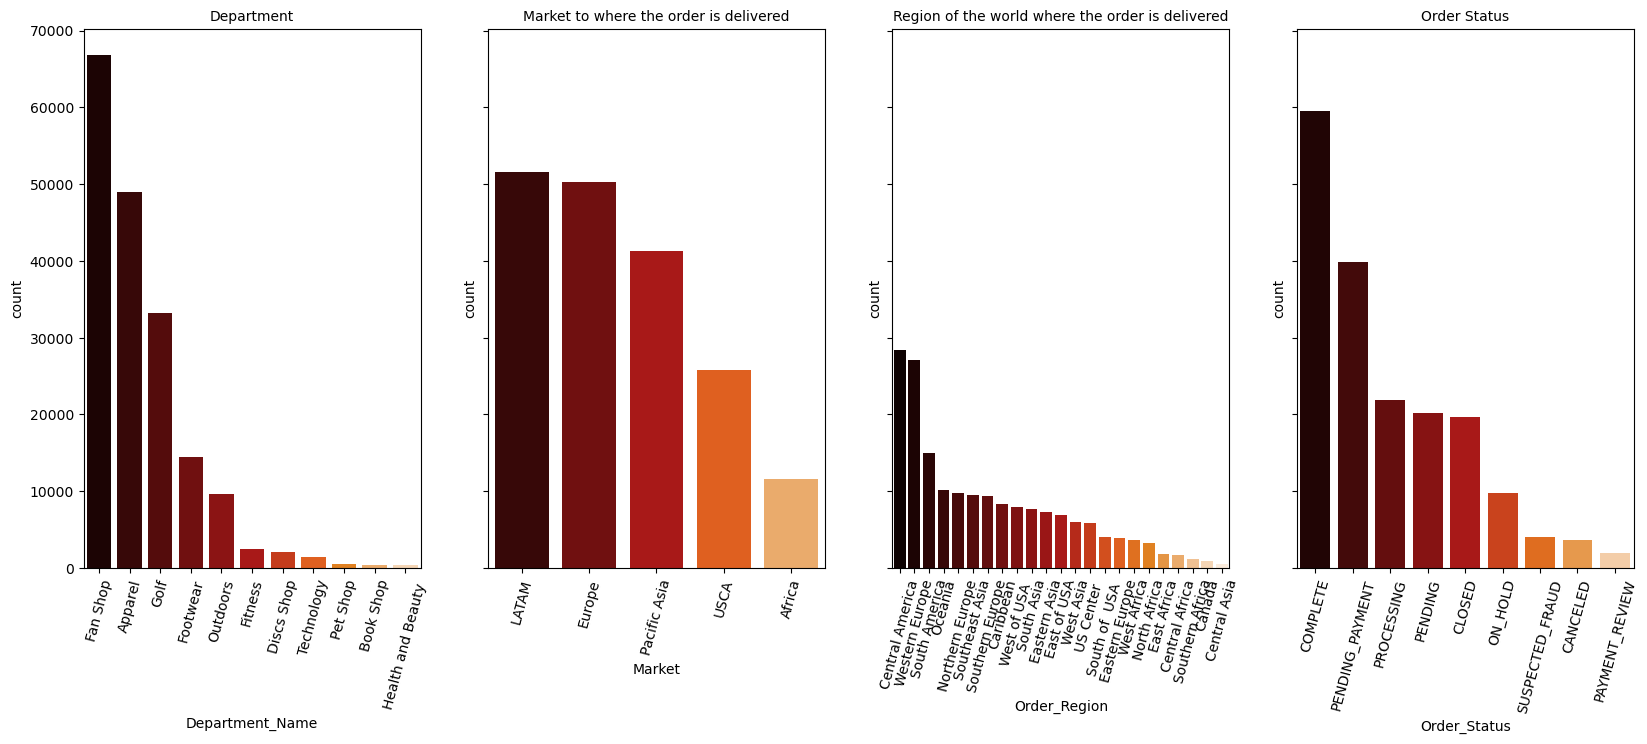

In [9]:
#Display Bar Charts (side-by-side) of Department, Market to where the order is delivered, Region of the world where the order is delivered, Order Status

def categ_count_xy_side_by_side(categ_vars, titles):
    fig, axes = plt.subplots(1, len(categ_vars), sharey=True)

    for i, categ_var in enumerate(categ_vars):
        sns.countplot(data = shipment_df, x = shipment_df[categ_var], order = shipment_df[categ_var].value_counts().index, palette = 'gist_heat', ax = axes[i])
        axes[i].set_title(titles[i], size = 10)
        axes[i].set_xlabel(categ_var)
        axes[i].tick_params(axis = 'x', rotation = 75)  #Rotate x-axis labels by 45 degrees

    plt.show()

#Example usage
categ_vars_xy = ["Department_Name", "Market", "Order_Region", "Order_Status"]
titles_xy = ["Department", "Market to where the order is delivered", "Region of the world where the order is delivered", "Order Status"]

categ_count_xy_side_by_side(categ_vars_xy, titles_xy)

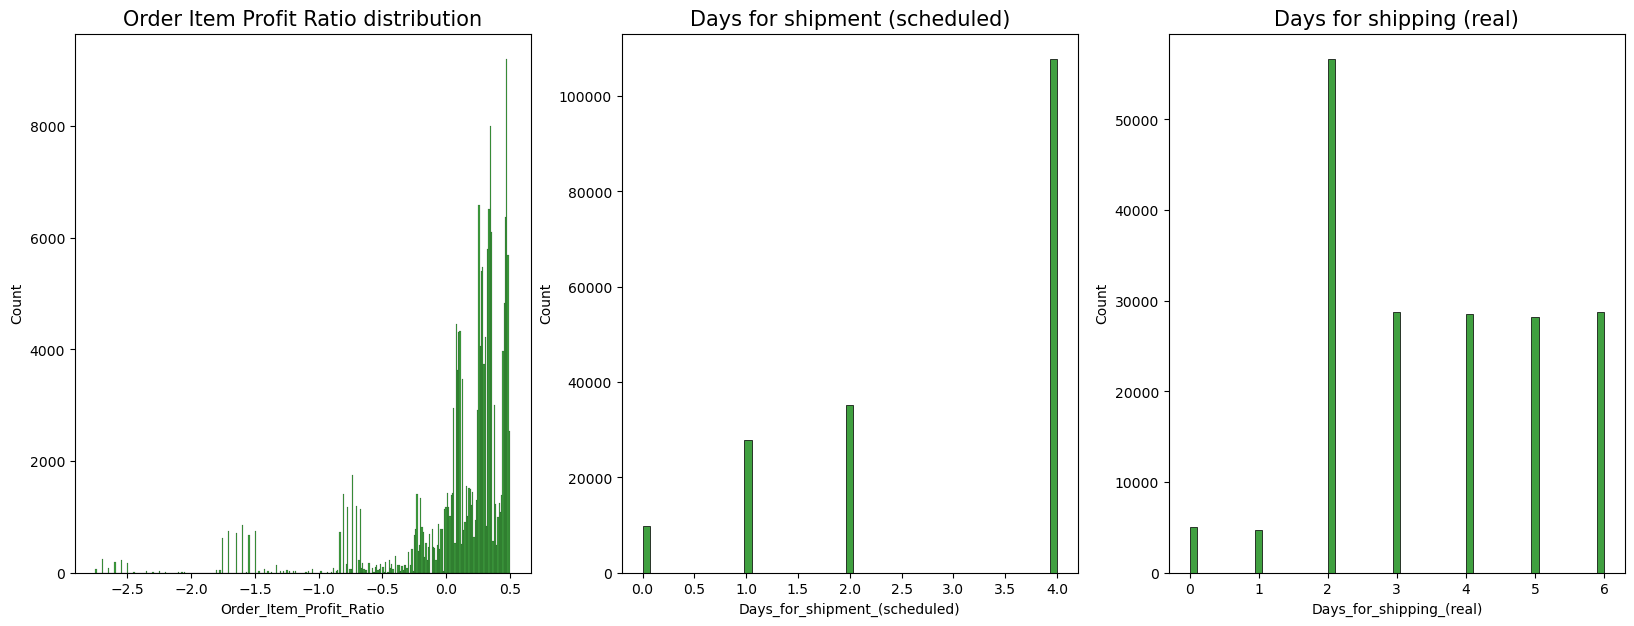

In [10]:
#Display histogram (side-by-side) of Order Item Profit Ratio distribution, Days for shipment (scheduled), Days for shipping (real)

plt.rcParams["figure.figsize"] = 20, 7  #Adjust figure size

def quant_count_side_by_side(num_vars, titles):
    fig, axes = plt.subplots(1, len(num_vars))

    for i, num_var in enumerate(num_vars):
        sns.histplot(shipment_df[num_var], kde=False, color="Green", ax=axes[i])
        axes[i].set_title(titles[i], size=15)
        axes[i].set_xlabel(num_var)

    plt.show()

num_vars = ["Order_Item_Profit_Ratio", "Days_for_shipment_(scheduled)", "Days_for_shipping_(real)"]
titles_quant = ["Order Item Profit Ratio distribution", "Days for shipment (scheduled)", "Days for shipping (real)"]

quant_count_side_by_side(num_vars, titles_quant)

Text(0.5, 1.0, 'Percentage of profitable and loser orders ')

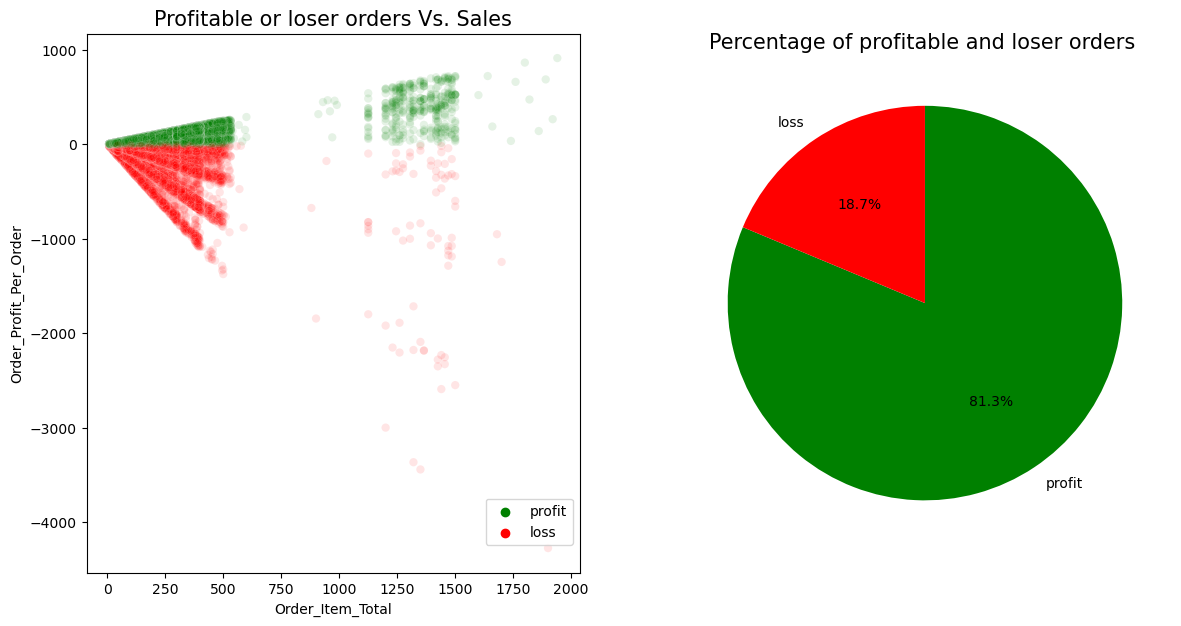

In [11]:
#Calculate profit / loss

shipment_df["profit_or_loss"] = np.where(shipment_df.Order_Profit_Per_Order>=0,"profit","loss")


#Display scatterplot and pie chart of  Profitable or loser orders vs Sales and Percentage of Profitable and loser orders

plt.figure(figsize = [14, 7])
plt.subplot(1, 2, 1)
sns.scatterplot( x = shipment_df.Order_Item_Total , y = shipment_df.Order_Profit_Per_Order , hue = shipment_df["profit_or_loss"] , 
               palette= ["g", "r"], alpha = 0.1)
plt.title("Profitable or loser orders Vs. Sales",size = 15)
plt.legend(bbox_to_anchor = (1,0.15));
plt.subplot(1, 2, 2)

pie_data = shipment_df["profit_or_loss"].value_counts()
plt.pie(pie_data,labels = pie_data.index, startangle = 90, counterclock = False , autopct='%.1f%%',colors= ["g", "r"])
plt.title("Percentage of profitable and loser orders ",size = 15)

### Data Pre-Processing

In [12]:
#Create a LabelEncoder for columns (object)

label_encoders = {}
categorical_cols = shipment_df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    label_encoders[col] = LabelEncoder() #Create a LabelEncoder for each column
    shipment_df[col] = label_encoders[col].fit_transform(shipment_df[col])

In [13]:
#Display dataset after encoding data

shipment_df.head()

,Type,Days_for_shipping_(real),Days_for_shipment_(scheduled),Benefit_per_order,Sales_per_customer,Delivery_Status,Late_delivery_risk,Category_Id,Category_Name,Customer_City,...,Product_Card_Id,Product_Category_Id,Product_Description,Product_Image,Product_Name,Product_Price,Product_Status,shipping_date_(DateOrders),Shipping_Mode,profit_or_loss
0,1,3,4,91.250000,314.640015,0,0,73,40,66,...,1360,73,NaN,78,78,327.75,0,2018-02-03 22:56:00,3,1
1,3,5,4,-249.089996,311.359985,1,1,73,40,66,...,1360,73,NaN,78,78,327.75,0,2018-01-18 12:27:00,3,0
2,0,4,4,-247.779999,309.720001,3,0,73,40,452,...,1360,73,NaN,78,78,327.75,0,2018-01-17 12:06:00,3,0
3,1,3,4,22.860001,304.809998,0,0,73,40,285,...,1360,73,NaN,78,78,327.75,0,2018-01-16 11:45:00,3,1
4,2,2,4,134.210007,298.250000,0,0,73,40,66,...,1360,73,NaN,78,78,327.75,0,2018-01-15 11:24:00,3,1


### NN Model

In [14]:
#1st round -- pre-select the predictors
#Define predictors and outcome (target variable) = Late_delivery_risk

predictors = ['Shipping_Mode', 'Days_for_shipping_(real)', 'Days_for_shipment_(scheduled)', 
              'Type', 'Order_State', 'Order_Profit_Per_Order', 'Order_Item_Total', 'Product_Price', 
              'Order_Item_Quantity', 'Order_Region', 'Product_Status', 'Customer_Segment']
outcome = ['Late_delivery_risk']

X = shipment_df[predictors]
y = shipment_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.4, random_state = 1)

In [15]:
#Create new function 'train_model' and 'score_model'

def train_model(variable):
    model = LinearRegression()
    model.fit(train_X[list(variable)], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[list(variables)])
    return -adjusted_r2_score(train_y, pred_y, model)

#Creates a list of all independent variables ('allVariables')
#Call "exhaustive_search" function to perform an exhaustive search

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

#Create initialized data, then iterately loop results iterate through the "results". 
#Calculate the AIC (Akaike Info Criterion) score for the model's predictions using "AIC_score".

data = []
for result in results:
    model = result['model']
    variables = list(result['variables'])
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)

#Create dictionary (d) with info about the model, 
#including the number of variables (n), the negative adjusted R-squared score (r2adj), 
#and the AIC score (AIC).
  
    d = {'n' : result['n'], 'r2adj' : -result['score'], 'AIC' : AIC}
    d.update({var : var in result['variables'] for var in allVariables})
    data.append(d)

#Creates DF, include 'n' (number of variables), 'r2adj' (negative adjusted R-squared score), 
#'AIC' (AIC score), and a binary column for each variable to indicate their inclusion in the model.

pd.DataFrame(data, columns = ('n', 'r2adj', 'AIC') + tuple(sorted(allVariables)))

,n,r2adj,AIC,Customer_Segment,Days_for_shipment_(scheduled),Days_for_shipping_(real),Order_Item_Quantity,Order_Item_Total,Order_Profit_Per_Order,Order_Region,Order_State,Product_Price,Product_Status,Shipping_Mode,Type
0,1,0.161536,137113.551464,False,False,False,False,False,False,False,False,False,False,True,False
1,2,0.665992,37423.526385,False,False,True,False,False,False,False,False,False,False,True,False
2,3,0.673972,34804.444219,False,True,True,False,False,False,False,False,False,False,True,False
3,4,0.678167,33401.609525,False,True,True,False,False,False,False,False,False,False,True,True
4,5,0.678175,33399.007285,False,True,True,False,False,False,False,True,False,False,True,True
5,6,0.678178,33397.797162,False,True,True,False,False,True,False,True,False,False,True,True
6,7,0.678179,33397.560588,False,True,True,False,True,True,False,True,False,False,True,True
7,8,0.678180,33397.077174,False,True,True,False,True,True,False,True,True,False,True,True
8,9,0.678181,33396.818150,False,True,True,True,True,True,False,True,True,False,True,True
9,10,0.678182,33396.715145,True,True,True,True,True,True,False,True,True,False,True,True


In [16]:
#Backward Elimination Code
#Create new function 'train_model' and 'score_model'

def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[list(variables)], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

allVariables = train_X.columns
best_model, best_variables = backward_elimination(allVariables, train_model, score_model, verbose = True)

print(best_variables)

regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: Shipping_Mode, Days_for_shipping_(real), Days_for_shipment_(scheduled), Type, Order_State, Order_Profit_Per_Order, Order_Item_Total, Product_Price, Order_Item_Quantity, Order_Region, Product_Status, Customer_Segment
Start: score=33396.65
Step: score=33396.65, remove None
['Shipping_Mode', 'Days_for_shipping_(real)', 'Days_for_shipment_(scheduled)', 'Type', 'Order_State', 'Order_Profit_Per_Order', 'Order_Item_Total', 'Product_Price', 'Order_Item_Quantity', 'Order_Region', 'Product_Status', 'Customer_Segment']

Regression statistics

               Mean Error (ME) : -0.0009
Root Mean Squared Error (RMSE) : 0.2829
     Mean Absolute Error (MAE) : 0.2258


In [17]:
#Forward Selection Code
#The initial model is the constatn model - this requires special handling in train_model & score_model

def train_model(variables):
    if len(variables) == 0:
        return None
    
    model = LinearRegression()
    model.fit(train_X[list(variables)], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df = 1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_models, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose = True)
print(best_variables)

Variables: Shipping_Mode, Days_for_shipping_(real), Days_for_shipment_(scheduled), Type, Order_State, Order_Profit_Per_Order, Order_Item_Total, Product_Price, Order_Item_Quantity, Order_Region, Product_Status, Customer_Segment
Start: score=156195.23, constant
Step: score=137113.55, add Shipping_Mode
Step: score=37423.53, add Days_for_shipping_(real)
Step: score=34804.44, add Days_for_shipment_(scheduled)
Step: score=33401.61, add Type
Step: score=33399.01, add Order_State
Step: score=33397.80, add Order_Profit_Per_Order
Step: score=33397.56, add Order_Item_Total
Step: score=33397.08, add Product_Price
Step: score=33396.82, add Order_Item_Quantity
Step: score=33396.72, add Customer_Segment
Step: score=33396.65, add Order_Region
Step: score=33396.65, add None
['Shipping_Mode', 'Days_for_shipping_(real)', 'Days_for_shipment_(scheduled)', 'Type', 'Order_State', 'Order_Profit_Per_Order', 'Order_Item_Total', 'Product_Price', 'Order_Item_Quantity', 'Customer_Segment', 'Order_Region']


In [18]:
#Stepwise

best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose = True)
print(best_variables)

Variables: Shipping_Mode, Days_for_shipping_(real), Days_for_shipment_(scheduled), Type, Order_State, Order_Profit_Per_Order, Order_Item_Total, Product_Price, Order_Item_Quantity, Order_Region, Product_Status, Customer_Segment
Start: score=156195.23, constant
Step: score=137113.55, add Shipping_Mode
Step: score=37423.53, add Days_for_shipping_(real)
Step: score=34804.44, add Days_for_shipment_(scheduled)
Step: score=33401.61, add Type
Step: score=33399.01, add Order_State
Step: score=33397.80, add Order_Profit_Per_Order
Step: score=33397.56, add Order_Item_Total
Step: score=33397.08, add Product_Price
Step: score=33396.82, add Order_Item_Quantity
Step: score=33396.72, add Customer_Segment
Step: score=33396.65, add Order_Region
Step: score=33396.65, unchanged None
['Shipping_Mode', 'Days_for_shipping_(real)', 'Days_for_shipment_(scheduled)', 'Type', 'Order_State', 'Order_Profit_Per_Order', 'Order_Item_Total', 'Product_Price', 'Order_Item_Quantity', 'Customer_Segment', 'Order_Region']


In [19]:
#2nd round -- selected predictors based on stepwise
#Define predictors and outcome (target variable) = Late_delivery_risk

predictors = ['Shipping_Mode', 'Days_for_shipping_(real)', 'Days_for_shipment_(scheduled)', 
              'Type', 'Order_State', 'Order_Profit_Per_Order', 'Order_Item_Total', 'Product_Price', 
              'Order_Item_Quantity', 'Customer_Segment', 'Order_Region']
outcome = ['Late_delivery_risk']

X = shipment_df[predictors]
y = shipment_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.4, random_state = 1)

In [20]:
#Convert the target variable to a ID array

train_y = train_y[outcome].values.ravel()
valid_y = valid_y[outcome].values.ravel()

In [21]:
#Standardize the features

scaler = StandardScaler()

train_X_scaled = scaler.fit_transform(train_X)
valid_X_scaled = scaler.transform(valid_X)

In [22]:
#Create NN model & train Neural Network 

clf = MLPClassifier(hidden_layer_sizes = (10,5), activation = 'relu', solver = 'adam', random_state = 1, max_iter = 200)
clf.fit(train_X_scaled, train_y)

MLPClassifier(hidden_layer_sizes=(10, 5), random_state=1)

#### Note:

1) hidden_layer_sizes = (10, 5) : To defines the structure of the neural network. In this case, there are two hidden layers with 10 and 5 neurons, respectively.

2) activation='relu' : specifies the activation function for the hidden layers, in this case, the Rectified Linear Unit (ReLU) activation function.

3) solver='adam' : is the optimization algorithm used to minimize the loss function during training. Adam is a popular optimization algorithm.

4) max_iter=200 : sets the maximum number of iterations (or epochs) for which the solver should converge. If convergence is not achieved within this limit, the optimization stops.

In [23]:
#Prediction and Network Structure

#Predictions on the test set
prediction = clf.predict(valid_X_scaled)
print(prediction)

#Network Structure
print('Intercepts')
print(clf.intercepts_)

[0 1 1 ... 0 0 1]
Intercepts
[array([ 0.36163253,  0.62522253,  0.85035548,  1.23209504, -0.88637554,
        0.24875942,  0.59891312,  0.39098295,  0.54349343,  0.30408846]), array([ 0.55516039,  0.98191602,  0.18620428, -0.14008555,  0.30737433]), array([0.1662304])]


In [24]:
#Model Performance

#Training performance
classificationSummary(train_y, clf.predict(train_X_scaled))

#Validation performance
classificationSummary(valid_y, clf.predict(valid_X_scaled))

Confusion Matrix (Accuracy 0.9756)

       Prediction
Actual     0     1
     0 46243  2641
     1     0 59427
Confusion Matrix (Accuracy 0.9753)

       Prediction
Actual     0     1
     0 30876  1782
     1     0 39550


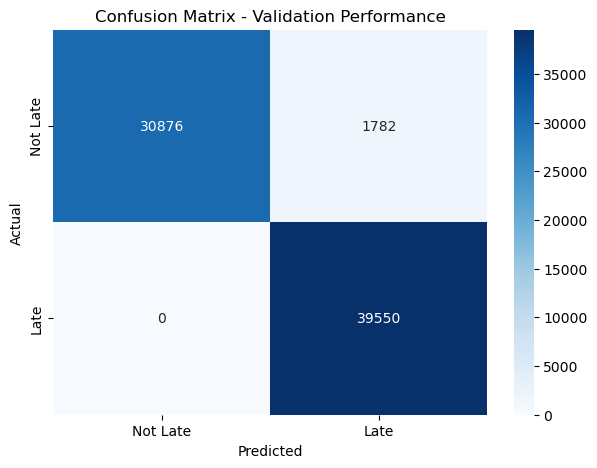

In [25]:
#Get predictions on the validation set
valid_predictions = clf.predict(valid_X_scaled)

#Calculate confusion matrix
cm = confusion_matrix(valid_y, valid_predictions)

# Plot heatmap
plt.figure(figsize = (7, 5))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['Not Late', 'Late'], yticklabels = ['Not Late', 'Late'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Performance')
plt.show()

### Random Forest Classifier Model

In [26]:
#Create and train a Random Forest classifier

rfc = RandomForestClassifier(n_estimators = 300, random_state = 42)
rfc.fit(train_X_scaled, train_y)

RandomForestClassifier(n_estimators=300, random_state=42)

In [27]:
#Make predictions on the test set

y_pred = rfc.predict(valid_X_scaled)

In [28]:
#Model Performance

#Training performance
classificationSummary(train_y, rfc.predict(train_X_scaled))

#Validation performance
classificationSummary(valid_y, rfc.predict(valid_X_scaled))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual     0     1
     0 48884     0
     1     0 59427
Confusion Matrix (Accuracy 0.9756)

       Prediction
Actual     0     1
     0 30942  1716
     1    44 39506


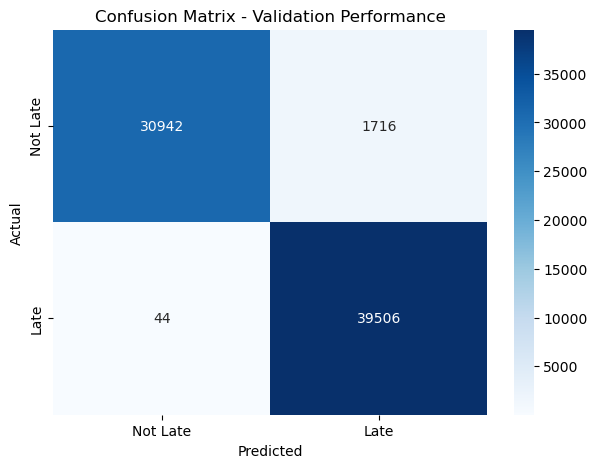

In [29]:
#Get predictions on the validation set
valid_predictions = rfc.predict(valid_X_scaled)

#Calculate confusion matrix
cm = confusion_matrix(valid_y, valid_predictions)

#Plot heatmap
plt.figure(figsize = (7, 5))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['Not Late', 'Late'], yticklabels = ['Not Late', 'Late'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Performance')
plt.show()

In [1]:
#For the given data in table01 use x1 and x3 as inputs and y3 as the output, write a Python code with Jupyter Notebook to build and run a neural network model for different numbers of neurons in the hidden layer (3, 6, and 9). It is good to have a bar graph for comparison 